In [56]:
import numpy as np
import matplotlib.pyplot as plt
import ot

# ---- knobs ----
n = 10  # number of points
epsilon = 0.05  # entropic regularization strength
source = "gaussian"  # "disk", "gaussian", "gaussian_mixture", "banana"
mass_mode = "uniform"  # "uniform", "dirichlet", "lognormal"
mass_alpha = 0.5  # used for dirichlet only

rng = np.random.default_rng(0)

def sample_source(n, kind="gaussian"):
    if kind == "disk":
        # Uniform in unit disk via inverse CDF for radius
        theta = rng.uniform(0, 2*np.pi, size=n)
        r = np.sqrt(rng.uniform(0, 1, size=n))
        return np.c_[r * np.cos(theta), r * np.sin(theta)]
    if kind == "gaussian":
        mean = np.array([1.5, 0.0])
        cov = np.array([[0.6, 0.2],[0.2, 0.4]])
        return rng.multivariate_normal(mean, cov, size=n)
    if kind == "gaussian_mixture":
        n1 = n // 2
        n2 = n - n1
        x1 = rng.multivariate_normal([2.0, 0.5], [[0.2, 0.0],[0.0, 0.2]], size=n1)
        x2 = rng.multivariate_normal([-1.5, -0.5], [[0.3, 0.0],[0.0, 0.3]], size=n2)
        return np.vstack([x1, x2])
    if kind == "banana":
        x = rng.normal(size=(n, 2))
        x[:, 1] += 0.2 * (x[:, 0]**2) - 1.0
        x[:, 0] *= 1.2
        return x
    raise ValueError("Unknown source")

def sample_target_circle(n):
    theta = rng.uniform(0, 2*np.pi, size=n)
    return np.c_[np.cos(theta), np.sin(theta)]

def make_weights(n, mode="uniform", alpha=0.5):
    if mode == "uniform":
        w = np.ones(n)
    elif mode == "dirichlet":
        w = rng.dirichlet(alpha * np.ones(n))
    elif mode == "lognormal":
        w = np.exp(rng.normal(size=n))
    else:
        raise ValueError("Unknown mass mode")
    return w / w.sum()


# ---- sample ----
n_target = 100
Xs = np.exp(np.random.randn(10, 2))
Xt = sample_source(n_target, "disk")

/Users/vladimir.kondratyev/conformal_prediction_in_large_dimensions/.venv/lib/python3.13/site-packages/ot/bregman/_sinkhorn.py:666: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


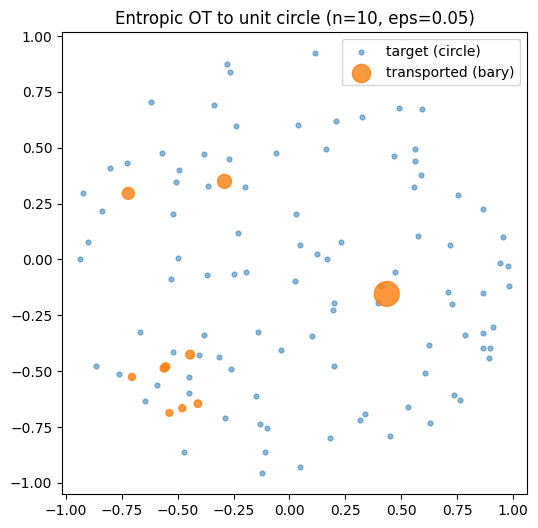

In [61]:
a = np.linalg.norm(Xs, axis=1) ** 2
a /= a.sum()
# a = np.ones(10) / 10
b = np.ones(n_target) / n_target

# cost matrix (squared Euclidean)
C = ot.dist(Xs, Xt, metric="sqeuclidean")

# entropic OT plan
P = ot.sinkhorn(a, b, C, reg=1e-1)

# barycentric projection to target
Xt_bary = (P @ Xt) / (P.sum(axis=1, keepdims=True) + 1e-12)

# ---- plot ----
# size reflects initial mass a
s_source = 20 + 300 * (a / a.max())

plt.figure(figsize=(6,6))
# plt.scatter(Xs[:,0], Xs[:,1], s=s_source, alpha=0.6, label="source (mass-sized)")
plt.scatter(Xt[:,0], Xt[:,1], s=12, alpha=0.5, label="target (circle)")
plt.scatter(Xt_bary[:,0], Xt_bary[:,1], s=s_source, alpha=0.8, label="transported (bary)")
plt.axis("equal")
plt.legend()
plt.title(f"Entropic OT to unit circle (n={n}, eps={epsilon})")
plt.show()
